In [1]:
!pip install pytorchvideo

from IPython import display

display.clear_output()

In [2]:
#-- Import Libraries -------------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.models.video import mvit_v2_s
from torchvision.models import efficientnet_b2

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple
import os
from sklearn.cluster import KMeans
import json 
import pickle
from collections import defaultdict
import random
import glob
#---------------------------------------------------------------------------------------------------------

In [3]:
#-- Initialize -----------------------------------------------------------------------------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {DEVICE}')

NUM_CLASSES = 2
CLASS_NAMES = ['normal', 'fight']

NUM_FRAMES = 16
FRAME_W = 224
FRAME_H = 224

TARGET_LAYER_INDEX = -1
FRAME_INDICES = [1, 3, 5, 7, 9, 11, 13, 15]
NUM_ATTENDED_FRAMES = 8

key_frames_dir = '/kaggle/input/n-violence-preprocess-test-violence-frames/KeyFrames'
video_tensors_dir = '/kaggle/input/n-violence-preprocess-test-violence/Violence/video_tensors'
indices_dir = '/kaggle/input/n-violence-preprocess-test-violence/Violence/frame_indices'
clusters_dict_dir = '/kaggle/input/n-violence-preprocess-test-violence/Violence/cluster_dicts'
mvit_best_witghts_path = '/kaggle/input/violence-best-weights/best_model_iter_1.pt'
videos_dir = '/kaggle/input/n-create-fight-ds-fight-samples/test/fights'
bbox_dirs = ["/kaggle/input/yolo-boundingbox-violence/yolo-boundbox-violence-15/obj_train_data",
             "/kaggle/input/yolo-boundingbox-violence/yolo-boundbox-violence-50-first/obj_train_data",
             "/kaggle/input/yolo-boundingbox-violence/yolo-boundbox-violence-50-second/obj_train_data"
            ]
#---------------------------------------------------------------------------------------------------------

device: cuda


In [4]:
#-- Mvit Model Definition ----------------------------------------------------------------------------------
class VideoMViTModel(nn.Module):
    def __init__(self, num_classes=2):
        super(VideoMViTModel, self).__init__()        
        
        self.model = mvit_v2_s(weights=None)        
        self.model.head = nn.Linear(768, num_classes)   
        
        weights_path = torch.load(mvit_best_witghts_path)
        model_state = weights_path['model_state']
        
        #-- Remove the 'module.model.' prefix from each key --
        new_state_dict = {}
        for key, value in model_state.items():
            new_key = key.replace('model.', '')  
            new_state_dict[new_key] = value

        #-- Load the modified state dict --
        self.model.load_state_dict(new_state_dict)

    def forward(self, x):
        return self.model(x)
#---------------------------------------------------------------------------------------------------------

In [5]:
#-- Load the MViT model ------------------------------------------------------------------------------------
mvit_model = VideoMViTModel(num_classes=2).cuda()
if torch.cuda.device_count() > 1:
    mvit_model = nn.DataParallel(mvit_model)

mvit_model.eval()
print(':)')
#---------------------------------------------------------------------------------------------------------

/tmp/ipykernel_31/2856362789.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_path = torch.load(mvit_best_witghts_path)


:)


In [6]:
# #-- Load EfficentNet Model ----------------------------------------------------------------------------------
# eff_model = efficientnet_b2(weights='IMAGENET1K_V1')  
# eff_model = torch.nn.Sequential(*(list(eff_model.children())[:-2]), torch.nn.AdaptiveAvgPool2d((1, 1)))  #-- Remove top layers
# eff_model = eff_model.to(DEVICE).eval()  
# #---------------------------------------------------------------------------------------------------------

In [7]:
#-- Preprocessing for input frames -----------------------------------------------------------------------
transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])
#---------------------------------------------------------------------------------------------------------

In [8]:
#-- Function to  Extract all frames from a video ----------------------------------------------------------
def extract_all_frames(video_filename):    
     
    video_path = os.path.join(videos_dir, video_filename)      
    
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()
    while success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  #-- Convert BGR to RGB
        frames.append(transform(frame))
        success, frame = cap.read()
    cap.release()
    return torch.stack(frames).to(DEVICE)
#---------------------------------------------------------------------------------------------------------

In [9]:
#-- Function to  load key frames from a video ----------------------------------------------------------
def load_key_frames(video_filename):
    video_name = os.path.splitext(video_filename)[0]  #-- remove file extension
    frames_path = os.path.join(key_frames_dir, video_name)  
    
    frame_files = sorted([
        os.path.join(frames_path, f)
        for f in os.listdir(frames_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])    
    
    frames = []
    for frame_file in frame_files:
        img = cv2.imread(frame_file)
        if img is None:
            continue  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        frames.append(transform(img))
    
    return torch.stack(frames).to(DEVICE)
#---------------------------------------------------------------------------------------------------------

In [10]:
#-- Function to Preprocess videos -------------------------------------------------------------------------------
def load_preprocessed_video(video_filename):   
    
    video_name = os.path.splitext(video_filename)[0] #-- remove file extension 
    
    tensor_path = os.path.join(video_tensors_dir, f"{video_name}_tensor.pt")  
    video_tensor = torch.load(tensor_path, map_location=torch.device('cpu'))

    indices_path = os.path.join(indices_dir, f"{video_name}_indices.json")  
    with open(indices_path, "r") as f:
        sorted_frame_indices = json.load(f)    

    cluster_path = os.path.join(clusters_dict_dir, f"{video_name}_cluster.pkl")  
    with open(cluster_path, "rb") as f:
        cluster_dict = pickle.load(f)    

    return video_tensor, sorted_frame_indices, cluster_dict  
    
#-------------------------------------------------------------------------------------------------------------

In [11]:
#-- function to Predict video label ------------------------------------------------------------------------------
def predict_video(model, preprocessed_video, num_frames=NUM_FRAMES, resize=(FRAME_W, FRAME_H)):    
    
    with torch.no_grad():        
        outputs = model(preprocessed_video)
        _, predicted = torch.max(outputs, 1)      
    
    return CLASS_NAMES[predicted.item()]   
#-----------------------------------------------------------------------------------------------------------------

In [12]:
#-- link of MviT Source Code --------------------------------------------------------------------------------------
#https://github.com/pytorch/vision/blob/main/torchvision/models/video/mvit.py
#-----------------------------------------------------------------------------------------------------------------

In [13]:
#-- Required functions for forward from Source Code --------------------------------------------------------------
#------------------------------------------------------------------------
def _add_rel_pos(
    attn: torch.Tensor,
    q: torch.Tensor,
    q_thw: Tuple[int, int, int],
    k_thw: Tuple[int, int, int],
    rel_pos_h: torch.Tensor,
    rel_pos_w: torch.Tensor,
    rel_pos_t: torch.Tensor,) -> torch.Tensor:
    # Modified code from: https://github.com/facebookresearch/SlowFast/commit/1aebd71a2efad823d52b827a3deaf15a56cf4932
    q_t, q_h, q_w = q_thw
    k_t, k_h, k_w = k_thw
    dh = int(2 * max(q_h, k_h) - 1)
    dw = int(2 * max(q_w, k_w) - 1)
    dt = int(2 * max(q_t, k_t) - 1)

    # Scale up rel pos if shapes for q and k are different.
    q_h_ratio = max(k_h / q_h, 1.0)
    k_h_ratio = max(q_h / k_h, 1.0)
    dist_h = torch.arange(q_h)[:, None] * q_h_ratio - (torch.arange(k_h)[None, :] + (1.0 - k_h)) * k_h_ratio
    q_w_ratio = max(k_w / q_w, 1.0)
    k_w_ratio = max(q_w / k_w, 1.0)
    dist_w = torch.arange(q_w)[:, None] * q_w_ratio - (torch.arange(k_w)[None, :] + (1.0 - k_w)) * k_w_ratio
    q_t_ratio = max(k_t / q_t, 1.0)
    k_t_ratio = max(q_t / k_t, 1.0)
    dist_t = torch.arange(q_t)[:, None] * q_t_ratio - (torch.arange(k_t)[None, :] + (1.0 - k_t)) * k_t_ratio

    # Interpolate rel pos if needed.
    rel_pos_h = _interpolate(rel_pos_h, dh)
    rel_pos_w = _interpolate(rel_pos_w, dw)
    rel_pos_t = _interpolate(rel_pos_t, dt)
    Rh = rel_pos_h[dist_h.long()]
    Rw = rel_pos_w[dist_w.long()]
    Rt = rel_pos_t[dist_t.long()]

    B, n_head, _, dim = q.shape

    r_q = q[:, :, 1:].reshape(B, n_head, q_t, q_h, q_w, dim)
    rel_h_q = torch.einsum("bythwc,hkc->bythwk", r_q, Rh)  # [B, H, q_t, qh, qw, k_h]
    rel_w_q = torch.einsum("bythwc,wkc->bythwk", r_q, Rw)  # [B, H, q_t, qh, qw, k_w]
    # [B, H, q_t, q_h, q_w, dim] -> [q_t, B, H, q_h, q_w, dim] -> [q_t, B*H*q_h*q_w, dim]
    r_q = r_q.permute(2, 0, 1, 3, 4, 5).reshape(q_t, B * n_head * q_h * q_w, dim)
    # [q_t, B*H*q_h*q_w, dim] * [q_t, dim, k_t] = [q_t, B*H*q_h*q_w, k_t] -> [B*H*q_h*q_w, q_t, k_t]
    rel_q_t = torch.matmul(r_q, Rt.transpose(1, 2)).transpose(0, 1)
    # [B*H*q_h*q_w, q_t, k_t] -> [B, H, q_t, q_h, q_w, k_t]
    rel_q_t = rel_q_t.view(B, n_head, q_h, q_w, q_t, k_t).permute(0, 1, 4, 2, 3, 5)

    # Combine rel pos.
    rel_pos = (
        rel_h_q[:, :, :, :, :, None, :, None]
        + rel_w_q[:, :, :, :, :, None, None, :]
        + rel_q_t[:, :, :, :, :, :, None, None]
    ).reshape(B, n_head, q_t * q_h * q_w, k_t * k_h * k_w)

    # Add it to attention
    attn[:, :, 1:, 1:] += rel_pos

    return attn
#------------------------------------------------------------------------

#------------------------------------------------------------------------
def _interpolate(embedding: torch.Tensor, d: int) -> torch.Tensor:
    if embedding.shape[0] == d:
        return embedding

    return (
        nn.functional.interpolate(
            embedding.permute(1, 0).unsqueeze(0),
            size=d,
            mode="linear",
        )
        .squeeze(0)
        .permute(1, 0)
    )
#------------------------------------------------------------------------

#------------------------------------------------------------------------
def _add_shortcut(x: torch.Tensor, shortcut: torch.Tensor, residual_with_cls_embed: bool):
    if residual_with_cls_embed:
        x.add_(shortcut)
    else:
        x[:, :, 1:, :] += shortcut[:, :, 1:, :]
    return x
#------------------------------------------------------------------------

#-----------------------------------------------------------------------------------------------------------------

In [14]:
#--Override Forward Function to get Attention Map and Cls weights -----------------------------------------------------
def my_forward_wrapper_video(attn_obj):
    
    def my_forward(x, thw):
        B, N, C = x.shape

        q, k, v = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, attn_obj.head_dim).transpose(1, 3).unbind(dim=2)
        if attn_obj.pool_k is not None:
            k, k_thw = attn_obj.pool_k(k, thw)
        else:
            k_thw = thw
        if attn_obj.pool_v is not None:
            v = attn_obj.pool_v(v, thw)[0]
        if attn_obj.pool_q is not None:
            q, thw = attn_obj.pool_q(q, thw)        
        

        attn = torch.matmul(attn_obj.scaler * q, k.transpose(2, 3))
        if attn_obj.rel_pos_h is not None and attn_obj.rel_pos_w is not None and attn_obj.rel_pos_t is not None:
            attn = _add_rel_pos(
                attn,
                q,
                thw,
                k_thw,
                attn_obj.rel_pos_h,
                attn_obj.rel_pos_w,
                attn_obj.rel_pos_t,
            )
        attn = attn.softmax(dim=-1)

        
        
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 1:]
        
        # print('attn:', attn.shape)        
        # print('attn_obj.cls_attn_map:', attn_obj.cls_attn_map.shape)        

        x = torch.matmul(attn, v)
        if attn_obj.residual_pool:
            _add_shortcut(x, q, attn_obj.residual_with_cls_embed)
        x = x.transpose(1, 2).reshape(B, -1, attn_obj.output_dim)
        x = attn_obj.project(x)

        return x, thw
    
    return my_forward
#-----------------------------------------------------------------------------------------------------------------

In [15]:
#-- function to Unnormalize frames -----------------------------------------------------------------
def unnormalize(tensor):
    device = tensor.device  
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    return tensor * std + mean
#-----------------------------------------------------------------------------------------------------------------

In [16]:
#-- Apply Custom Forward on Target Layer ----------------------------------------------------------------------------
mvit_model.module.model.blocks[TARGET_LAYER_INDEX].attn.forward = my_forward_wrapper_video(mvit_model.module.model.blocks[TARGET_LAYER_INDEX].attn)
#-----------------------------------------------------------------------------------------------------------------

In [17]:
#-- ّFunction to Compute scores for all heads usign different measures --------------------------------------
def compute_head_scores(cls_weight):
    scores = {}
    scores['mean'] = cls_weight.mean(dim=-1).squeeze(0)

    norm_attn = cls_weight / cls_weight.sum(dim=-1, keepdim=True)
    entropy = -(norm_attn * torch.log(norm_attn + 1e-6)).sum(dim=-1).squeeze(0)
    scores['entropy'] = -entropy  

    scores['variance'] = cls_weight.var(dim=-1).squeeze(0)
    return scores
#---------------------------------------------------------------------------------------------------------

In [18]:
#-- ّFunction to Compute center based score ---------------------------------------------------------------------------
def compute_center_based_scores(frame_attn):
    
    center_based_scores = []        
    for head in range(frame_attn.shape[0]):
        attn_patch = frame_attn[head].view(7, 7)            
        center_attn = attn_patch[2:5, 2:5]  
        score = center_attn.mean().item()
        center_based_scores.append(score)       
       
    center_based_top_head = np.argmax(center_based_scores)
    return center_based_top_head    
#---------------------------------------------------------------------------------------------------------

In [19]:
#-- Function to load violence boundinc box on frames -----------------------------------------------------
def load_yolo_bboxes(folder_path):
    bbox_dict = {}

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt") and filename.startswith("frame_"):
            frame_id = int(filename.split("_")[1].split(".")[0])  
            filepath = os.path.join(folder_path, filename)

            with open(filepath, "r") as f:
                content = f.read().strip()  
                bbox_dict[frame_id] = content

    return bbox_dict
#---------------------------------------------------------------------------------------------------------

In [20]:
#-- Function to convert YOLO Bounding Boxes to Pixel Coordinates on frame -------------------------------------
def get_yolo_bbox_pixel_coords(yolo_bbox_line, width=FRAME_W, height=FRAME_W):
    parts = yolo_bbox_line.strip().split()
    if len(parts) != 5:
        return None  
    _, x_center, y_center, bw, bh = map(float, parts)
    x1 = int((x_center - bw / 2) * width)
    y1 = int((y_center - bh / 2) * height)
    x2 = int((x_center + bw / 2) * width)
    y2 = int((y_center + bh / 2) * height)
    return x1, y1, x2, y2
#---------------------------------------------------------------------------------------------------------

In [21]:
#-- Function to Plot Bounding Boxes on Frames --------------------------------------------------------------
def plot_bbox(bboxes , ax, frame_indices, idx):     
    x1, y1, x2, y2 = bboxes[0], bboxes[1], bboxes[2], bboxes[3]
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='lime', facecolor='none')        
    ax.add_patch(rect)    
#---------------------------------------------------------------------------------------------------------

In [22]:
#-- Function to Get Bounding Box for Attention/HeatMaps ----------------------------------------------------
def get_attention_bbox_coords(attn_map, method="percentile", param=90):
    if method == "percentile":
        threshold = np.percentile(attn_map, param)
    elif method == "mean_std":
        mean = np.mean(attn_map)
        std = np.std(attn_map)
        threshold = mean + param * std  
    else:
        threshold = 0.6  

    mask = attn_map >= threshold
    ys, xs = np.where(mask)
    if len(xs) == 0 or len(ys) == 0:
        return None
    x1, y1 = np.min(xs), np.min(ys)
    x2, y2 = np.max(xs), np.max(ys)
    return x1, y1, x2, y2
#---------------------------------------------------------------------------------------------------------

In [23]:
#--function to compute IOU for Violenece BBox and Heatmap -----------------------------------------------------
def compute_iou(boxA, boxB):
    if boxA is None or boxB is None:
        return 0.0
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou
#---------------------------------------------------------------------------------------------------------

In [24]:
#-- Get All Samples ------------------------------------------------------------------------------------------
#-- Extract video names from existed Bboxes --
all_video_names = set()
for bb_dir in bbox_dirs:
    image_paths = glob.glob(os.path.join(bb_dir, "*", "*.txt"))

    for path in image_paths:
        video_name = os.path.basename(os.path.dirname(path))        
        all_video_names.add(video_name)        

all_video_names = sorted(all_video_names)

print(f"Number of Samples: {len(all_video_names)}")
# print(all_video_names)

#-- Extract full name and path for all video samples --
all_violence_videos = {}

for name in all_video_names:   
    pattern = os.path.join(videos_dir, f"{name}.*")
    matched_files = glob.glob(pattern)
    
    if matched_files:
        full_path = matched_files[0]
        file_with_ext = os.path.basename(full_path)
        
        all_violence_videos[name] = {
            'filename': file_with_ext,
            'filepath': full_path
        }
# print(all_violence_videos)

#-- Extract bbox dir for all samples --
all_bboxes = {}
for base_dir in bbox_dirs:
    if os.path.exists(base_dir):
        for name in os.listdir(base_dir):
            full_path = os.path.join(base_dir, name)
            if os.path.isdir(full_path):
                all_bboxes[name] = full_path
#---------------------------------------------------------------------------------------------------------

Number of Samples: 115


In [25]:
#-- Split TP and FP results ------------------------------------------------------------------------------
TP = []
FN = []

for video_name in all_video_names:
    print(f'\n\nprocessing {video_name} ============================================================')        

    video_full_name = all_violence_videos[video_name]['filename']
    
    
    video_tensor, frame_indices, _ = load_preprocessed_video(video_full_name)
    predicted_lbl = predict_video(mvit_model.to(DEVICE) , video_tensor.to(DEVICE))
    print('predicted_lbl:' , predicted_lbl)   

    if predicted_lbl=='fight':
        TP.append(video_full_name)
    else:
        FN.append(video_full_name)

display.clear_output()
print(f'TP= {len(TP)}\nFN= {len(FN)}')
#---------------------------------------------------------------------------------------------------------

TP= 105
FN= 10


In [26]:
#-- Function to Run --------------------------------------------------------------------------------------------
def run(attention_bbox_method , attention_bbox_param):

    all_videos_iou_scores_top_heads = {}
    all_videos_iou_scores_all_heads = {}
    
    for video_name in all_video_names:
        # print(f'\n\nprocessing {video_name} ============================================================')        
    
        video_full_name = all_violence_videos[video_name]['filename']    
        video_path = all_violence_videos[video_name]['filepath']
        
        if video_full_name not in TP:
            continue
        
        video_tensor, frame_indices, _ = load_preprocessed_video(video_full_name)    
        key_frames = load_key_frames(video_full_name)
        all_frames = extract_all_frames(video_full_name)
        bboxes = load_yolo_bboxes(all_bboxes[video_name])       
        
        #-- get attention map for last block --    
        predicted_lbl = predict_video(mvit_model.to(DEVICE) , video_tensor.to(DEVICE))
        cls_weight = mvit_model.module.model.blocks[-1].attn.cls_attn_map  
        patches_per_frame = cls_weight.shape[2] // NUM_ATTENDED_FRAMES  
        
        #-- compute head scores --
        scores_dict = compute_head_scores(cls_weight)
        top_heads = {name: torch.argmax(scores).item() for name, scores in scores_dict.items()}
        # print("Top heads by metric:", top_heads)
    
        #-- create dict for save iou values --
        top_heads_iou_scores = {"mean_all_heads": [],
                                "center_based": [],
                                "mean": [],
                                "entropy": [],
                                "variance": [],
                               }
        
        all_heads_iou_scores = {}
        for h in range(NUM_ATTENDED_FRAMES):
            all_heads_iou_scores[f"head_{h}"] = []
        
        #-- get attention for each frame --
        framewise_attn = []
        for i in range(NUM_ATTENDED_FRAMES):
            start = i * patches_per_frame
            end = (i + 1) * patches_per_frame
            frame_attn = cls_weight[0, :, start:end]
            framewise_attn.append(frame_attn)    
        
        for i, frame_attn in enumerate(framewise_attn):
            for j in range(2):
                idx = i * 2 + j
                frame_idx = frame_indices[idx]
                x = all_frames[frame_idx]            
                img_resized = x.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5    
        
                top_heads["center_based"] = compute_center_based_scores(frame_attn)       
        
                #-- resize all heads --
                cls_resized_all_heads = []
                for head in range(frame_attn.shape[0]):
                    cls_weight_head = frame_attn[head]
                    cls_weight_2d = cls_weight_head.view(1, 7, 7).unsqueeze(0)
                    cls_resized = F.interpolate(cls_weight_2d, size=(224, 224), mode='bilinear', align_corners=False)
                    cls_resized_all_heads.append(cls_resized)
        
                cls_resized_all_heads = torch.stack(cls_resized_all_heads)  # [8, 1, 224, 224]
                cls_resized_normalized = cls_resized_all_heads / cls_resized_all_heads.max()
                
                gt_line = bboxes[frame_indices[idx]]
                yolo_bbox = get_yolo_bbox_pixel_coords(gt_line)         
                # print('yolo_bbox:', yolo_bbox)           
                          
        
                #-- plot all heads --
                num_heads = cls_resized_normalized.shape[0]
                
                for h in range(num_heads):
                    attn_map = cls_resized_normalized[h].squeeze().cpu().numpy()
                    attn_bbox = get_attention_bbox_coords(attn_map, method=attention_bbox_method, param=attention_bbox_param)
                    # attn_bbox = get_attention_bbox_coords(attn_map, method="mean_std", param=0.6)
                    iou = compute_iou(yolo_bbox, attn_bbox)
                    all_heads_iou_scores[f"head_{h}"].append(iou)  
                
                # fig, axes = plt.subplots(1, num_heads, figsize=(5 * num_heads, 5))
                # for h in range(num_heads):
                #     attn_map_single = cls_resized_normalized[h].squeeze().cpu().numpy()
                #     axes[h].imshow(img_resized)
                #     axes[h].imshow(attn_map_single, cmap='jet', alpha=0.5)    
                #     if yolo_bbox!=None:
                #         plot_bbox(yolo_bbox , axes[h], frame_indices, idx)               
                #     axes[h].set_title(f"Head {h} - Frame {frame_idx}")
                #     axes[h].axis('off')
                # plt.tight_layout()
                # plt.show()
        
                #-- average of heads --
                mean_attn_map = cls_resized_normalized.mean(dim=0).squeeze().cpu().numpy()              
                if yolo_bbox!= None:                
                    attn_bbox_mean = get_attention_bbox_coords(mean_attn_map, method=attention_bbox_method, param=attention_bbox_param)
                    # attn_bbox_mean = get_attention_bbox_coords(attn_map, method="mean_std", param=0.6)
                    iou_mean = compute_iou(yolo_bbox, attn_bbox_mean)
                    top_heads_iou_scores["mean_all_heads"].append(iou_mean)
                
                
                # fig, axes = plt.subplots(1, 5, figsize=(25, 5))
                
                # #-- plot avg of all heads --
                # axes[0].imshow(img_resized)
                # axes[0].imshow(mean_attn_map.squeeze(), cmap='jet', alpha=0.5)
                # axes[0].set_title("Mean of All Heads")
                # if yolo_bbox!=None:
                #     plot_bbox(yolo_bbox , axes[0], frame_indices, idx)
                # axes[0].axis('off')
                
                # #-- plot different top heads --
                # for i, (metric_name, head_idx) in enumerate(top_heads.items(), start=1):
                #     attn_map = cls_resized_normalized[head_idx].squeeze().cpu().numpy()
                #     axes[i].imshow(img_resized)
                #     axes[i].imshow(attn_map, cmap='jet', alpha=0.5)
                #     if yolo_bbox!=None:
                #         plot_bbox(yolo_bbox , axes[i], frame_indices, idx)
                #     axes[i].set_title(f"{metric_name} - Head {head_idx}")
                #     axes[i].axis('off')
                
                # plt.tight_layout()
                # plt.suptitle(f"Attention Maps - Frame {frame_idx}", fontsize=16)
                # plt.subplots_adjust(top=0.85)
                # plt.show()      
                
                if yolo_bbox!= None:
                    for metric_name, head_idx in top_heads.items():
                        attn_map_head = cls_resized_normalized[head_idx].squeeze().cpu().numpy()                    
                        
                        attn_bbox_mean = get_attention_bbox_coords(attn_map_head, method=attention_bbox_method, param=attention_bbox_param)
                        # attn_bbox_mean = get_attention_bbox_coords(attn_map, method="mean_std", param=0.6)
                        iou_head = compute_iou(yolo_bbox, attn_bbox_mean)                    
                        
                        if metric_name not in top_heads_iou_scores:
                            top_heads_iou_scores[metric_name] = []
                        
                        top_heads_iou_scores[metric_name].append(iou_head)   
    
                all_videos_iou_scores_top_heads[video_name] = top_heads_iou_scores
                all_videos_iou_scores_all_heads[video_name] = all_heads_iou_scores

    return all_videos_iou_scores_top_heads, all_videos_iou_scores_all_heads
    
#---------------------------------------------------------------------------------------------------------------

In [ ]:
#-- Run with Different settings -----------------------------------------------------------------------------------
attention_bbox_method = ['percentile', 'mean_std']
percentile_threshod = [50, 60, 70, 80, 90]
mean_std_threshod = [0.5, 0.6, 0.7, 0.8, 0.9]

top_heads_values = {}
all_heads_values = {}

for method in attention_bbox_method:
    if method=='percentile':
        threshods = percentile_threshod
    else:
        threshods = mean_std_threshod

    for th in threshods:
        print(f'running {method} with threshod {th} --------------------')
            
        all_videos_iou_scores_top_heads, all_videos_iou_scores_all_heads = run(attention_bbox_method = method,
                                                                               attention_bbox_param = th)

        top_heads_values[(method, th)] = all_videos_iou_scores_top_heads
        all_heads_values[(method, th)] = all_videos_iou_scores_all_heads
#---------------------------------------------------------------------------------------------------------------  

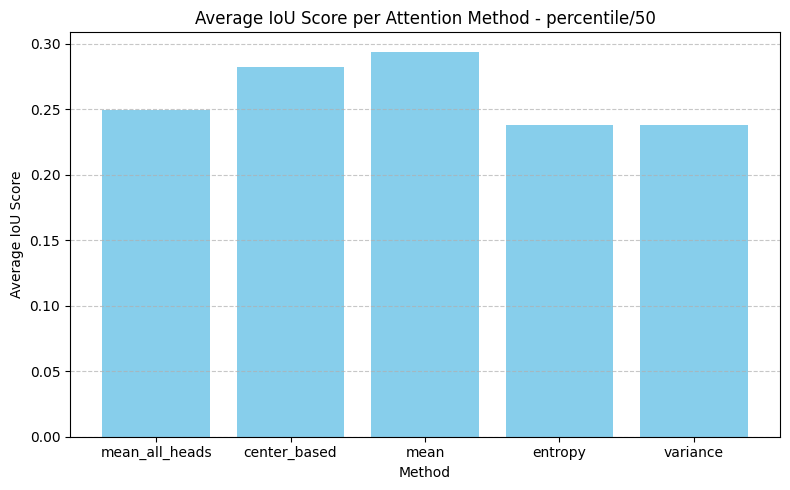

In [28]:
for (method, th),top_heads_iou_scores in top_heads_values.items():
    top_heads = {}
    for video_name , iou_score in top_heads_iou_scores.items():
        avg_iou_scores = {method: np.mean(scores) for method, scores in iou_score.items() if len(scores) > 0}
        top_heads[video_name] = avg_iou_scores
    
    
    sum_top_heads = {}
    count = len(top_heads)
    for values in top_heads.values():
        for k, v in values.items():
            sum_top_heads[k] = sum_top_heads.get(k, 0) + v
    mean_top_heads = {k: v / count for k, v in sum_top_heads.items()}
    
    plt.figure(figsize=(8, 5))
    plt.bar(mean_top_heads.keys(), mean_top_heads.values(), color='skyblue')
    plt.title(f'Average IoU Score per Attention Method - {method}/{th}')
    plt.ylabel('Average IoU Score')
    plt.xlabel('Method')
    # plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    

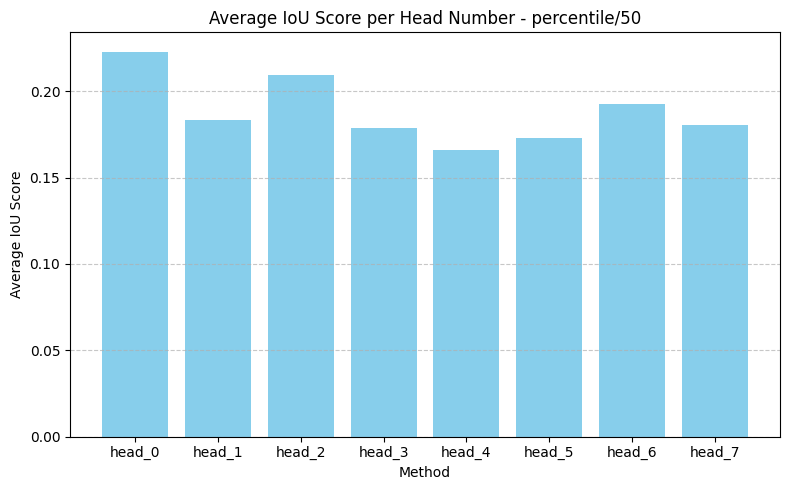

In [29]:
for (method, th),all_heads_iou_scores in all_heads_values.items():
    all_heads = {}
    for video_name , iou_score in all_heads_iou_scores.items():
        avg_iou_scores = {method: np.mean(scores) for method, scores in iou_score.items() if len(scores) > 0}
        all_heads[video_name] = avg_iou_scores
    
    
    sum_all_heads = {}
    count = len(all_heads)
    for values in all_heads.values():
        for k, v in values.items():
            sum_all_heads[k] = sum_all_heads.get(k, 0) + v
    mean_all_heads = {k: v / count for k, v in sum_all_heads.items()}
    
    plt.figure(figsize=(8, 5))
    plt.bar(mean_all_heads.keys(), mean_all_heads.values(), color='skyblue')
    plt.title(f'Average IoU Score per Head Number - {method}/{th}')
    plt.ylabel('Average IoU Score')
    plt.xlabel('Method')
    # plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()